In [ ]:
%load_ext pycodestyle_magic
%pycodestyle_on
%flake8_on

In [2]:
import collections
import cProfile
import hashlib
import itertools
import os
import pstats
import re
from datetime import datetime
from io import StringIO

# from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm
# import tqdm.notebook.tqdm as tqdm

import torch
import torchaudio
from torch import nn, topk
from torch.optim import Adadelta
from torch.utils.data import DataLoader
from torchaudio.datasets import SPEECHCOMMANDS, LIBRISPEECH
from torchaudio.transforms import MFCC

import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt

In [3]:
audio_backend = "soundfile"
device = "cuda" if torch.cuda.is_available() else "cpu"
num_workers = 0
pin_memory = False
non_blocking = pin_memory

excluded_dir = ["_background_noise_"]
folder_speechcommands = './SpeechCommands/speech_commands_v0.02'
labels = ["-", "*"] + [d for d in next(os.walk(folder_speechcommands))[1] if d not in excluded_dir]

# vocab_size = len(labels) + 2
shuffle = True
drop_last = True

# audio, self.sr, window_stride=(160, 80), fft_size=512, num_filt=20, num_coeffs=13
n_mfcc = 13
melkwargs = {
    'n_fft': 512,
    'n_mels': 20,
    'hop_length': 80,
}
sample_rate = 16000

batch_size = 1024  # max number of sentences per batch
optimizer_params = {
    "lr": 1.0,
    "eps": 1e-8,
    "rho": 0.95,
}

# hidden_size = 128
# num_layers = 3
hidden_size = 8
num_layers = 1

max_epoch = 200
mod_epoch = 10
clip_norm = 0.  # 10.

training_percentage = 80.
validation_percentage = 10.
MAX_NUM_WAVS_PER_CLASS = 2**27 - 1  # ~134M

dtstamp = datetime.now().strftime("%y%m%d.%H%M%S")

In [25]:
print(dtstamp)

200229.155832


In [4]:
# Profiling performance
pr = cProfile.Profile()
pr.enable()

torchaudio.set_audio_backend(audio_backend)
mfcc = MFCC(sample_rate=sample_rate, n_mfcc=n_mfcc, melkwargs=melkwargs)
mfcc.to(device)

MFCC(
  (amplitude_to_DB): AmplitudeToDB()
  (MelSpectrogram): MelSpectrogram(
    (spectrogram): Spectrogram()
    (mel_scale): MelScale()
  )
)

# Text encoding

In [5]:
class Coder:
    def __init__(self, labels):
        self.max_length = max(map(len, labels))

        labels = list(collections.OrderedDict.fromkeys(list("".join(labels))))
        self.length = len(labels)
        enumerated = list(enumerate(labels))
        flipped = [(sub[1], sub[0]) for sub in enumerated]

        d1 = collections.OrderedDict(enumerated)
        d2 = collections.OrderedDict(flipped)
        self.mapping = {**d1, **d2}

    def _map_and_pad(self, iterable, fillwith):
        iterable = [self.mapping[i] for i in iterable]  # map with dict
        iterable += [fillwith] * (self.max_length-len(iterable))  # add padding
        return iterable

    def encode(self, iterable):
        if isinstance(iterable[0], list):
            return [self.encode(i) for i in iterable]
        else:
            return self._map_and_pad(iterable, self.mapping["*"])

    def decode(self, tensor):
        if isinstance(tensor[0], list):
            return [self.decode(t) for t in tensor]
        else:
            return "".join(self._map_and_pad(tensor, self.mapping[1]))


coder = Coder(labels)
encode = coder.encode
decode = coder.decode
vocab_size = coder.length

# Dataset

In [6]:
class IterableMemoryCache:
    def __init__(self, iterable):
        self.iterable = iterable
        self.iter = iter(iterable)
        self.done = False
        self.vals = []

    def __iter__(self):
        if self.done:
            return iter(self.vals)
        # chain vals so far & then gen the rest
        return itertools.chain(self.vals, self._gen_iter())

    def _gen_iter(self):
        # gen new vals, appending as it goes
        for new_val in self.iter:
            self.vals.append(new_val)
            yield new_val
        self.done = True

    def __len__(self):
        return len(self.iterable)


class MapMemoryCache(torch.utils.data.Dataset):
    """
    Wrap a dataset so that, whenever a new item is returned, it is saved to memory.
    """

    def __init__(self, dataset):
        self.dataset = dataset
        self._id = id(self)
        self._cache = [None] * len(dataset)

    def __getitem__(self, n):
        if self._cache[n]:
            return self._cache[n]

        item = self.dataset[n]
        self._cache[n] = item

        return item

    def __len__(self):
        return len(self.dataset)

In [7]:
# @torch.jit.script
def process_datapoint(item):
    transformed = item[0].to(device, non_blocking=non_blocking)
    target = item[2]
    # pick first channel, apply mfcc, tranpose for pad_sequence
    transformed = mfcc(transformed)
    transformed = transformed[0, ...].transpose(0, -1)
    # transformed = transformed.view(-1, 1)
    target = encode(target)
    target = torch.tensor(target, dtype=torch.long, device=transformed.device)
    return transformed, target


class PROCESSED_LIBRISPEECH(LIBRISPEECH):

    def __getitem__(self, n):
        try:
            item = super().__getitem__(n)
            return process_datapoint(item)
        except (FileNotFoundError, RuntimeError):
            return None

    def __next__(self):
        try:
            item = super().__next__()
            return process_datapoint(item)
        except (FileNotFoundError, RuntimeError):
            return self.__next__()


def datasets():
    root = "./"

    training = PROCESSED_LIBRISPEECH(root, url="train-clean-100", download=True)
    training = MapMemoryCache(training)
    validation = PROCESSED_LIBRISPEECH(root, url="dev-clean", download=True)
    validation = MapMemoryCache(validation)

    return training, validation, None

In [8]:
# @torch.jit.script
def process_datapoint(item):
    transformed = item[0].to(device, non_blocking=non_blocking)
    target = item[2]
    # pick first channel, apply mfcc, tranpose for pad_sequence
    transformed = mfcc(transformed)
    transformed = transformed[0, ...].transpose(0, -1)
    # transformed = transformed.view(-1, 1)
    target = encode(target)
    target = torch.tensor(target, dtype=torch.long, device=transformed.device)
    return transformed, target


def which_set(filename, validation_percentage, testing_percentage):
    """Determines which data partition the file should belong to.

    We want to keep files in the same training, validation, or testing sets even
    if new ones are added over time. This makes it less likely that testing
    samples will accidentally be reused in training when long runs are restarted
    for example. To keep this stability, a hash of the filename is taken and used
    to determine which set it should belong to. This determination only depends on
    the name and the set proportions, so it won't change as other files are added.

    It's also useful to associate particular files as related (for example words
    spoken by the same person), so anything after '_nohash_' in a filename is
    ignored for set determination. This ensures that 'bobby_nohash_0.wav' and
    'bobby_nohash_1.wav' are always in the same set, for example.

    Args:
        filename: File path of the data sample.
        validation_percentage: How much of the data set to use for validation.
        testing_percentage: How much of the data set to use for testing.

    Returns:
        String, one of 'training', 'validation', or 'testing'.
    """
    base_name = os.path.basename(filename)
    # We want to ignore anything after '_nohash_' in the file name when
    # deciding which set to put a wav in, so the data set creator has a way of
    # grouping wavs that are close variations of each other.
    hash_name = re.sub(r'_nohash_.*$', '', base_name).encode("utf-8")
    # This looks a bit magical, but we need to decide whether this file should
    # go into the training, testing, or validation sets, and we want to keep
    # existing files in the same set even if more files are subsequently
    # added.
    # To do that, we need a stable way of deciding based on just the file name
    # itself, so we do a hash of that and then use that to generate a
    # probability value that we use to assign it.
    hash_name_hashed = hashlib.sha1(hash_name).hexdigest()
    percentage_hash = ((int(hash_name_hashed, 16) % (MAX_NUM_WAVS_PER_CLASS + 1)) * (100.0 / MAX_NUM_WAVS_PER_CLASS))
    if percentage_hash < validation_percentage:
        result = 'validation'
    elif percentage_hash < (testing_percentage + validation_percentage):
        result = 'testing'
    else:
        result = 'training'
    return result


class FILTERED_SPEECHCOMMANDS(SPEECHCOMMANDS):
    def __init__(self, tag, *args, **kwargs):
        super().__init__(*args, **kwargs)
        if training_percentage < 100.:
            testing_percentage = (100. - training_percentage - validation_percentage)
            self._walker = list(filter(lambda x: which_set(x, validation_percentage, testing_percentage) == tag, self._walker))


class PROCESSED_SPEECHCOMMANDS(FILTERED_SPEECHCOMMANDS):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def __getitem__(self, n):
        item = super().__getitem__(n)
        return process_datapoint(item)

    def __next__(self):
        item = super().__next__()
        return process_datapoint(item)


def datasets():
    root = "./"

    training = PROCESSED_SPEECHCOMMANDS("training", root, download=True)
    training = MapMemoryCache(training)
    validation = PROCESSED_SPEECHCOMMANDS("validation", root, download=True)
    validation = MapMemoryCache(validation)
    testing = PROCESSED_SPEECHCOMMANDS("testing", root, download=True)
    testing = MapMemoryCache(testing)

    return training, validation, testing

In [9]:
def collate_fn(batch):

    tensors = [b[0] for b in batch if b]
    targets = [b[1] for b in batch if b]

    # input_lengths = [t.shape[0] for t in tensors]
    # target_lengths = [len(t) for t in targets]

    targets = torch.nn.utils.rnn.pad_sequence(targets, batch_first=True)
    tensors = torch.nn.utils.rnn.pad_sequence(tensors, batch_first=True)
    tensors = tensors.transpose(1, -1)

    return tensors, targets  # , input_lengths, target_lengths

# Model

[Wav2Letter](https://github.com/LearnedVector/Wav2Letter/blob/master/Google%20Speech%20Command%20Example.ipynb)

In [10]:
class PrintLayer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        print(x)
        return x
    

class Wav2Letter(nn.Module):
    """Wav2Letter Speech Recognition model
        https://arxiv.org/pdf/1609.03193.pdf
        This specific architecture accepts mfcc or power spectrums speech signals

        Args:
            num_features (int): number of mfcc features
            num_classes (int): number of unique grapheme class labels
    """

    def __init__(self, num_features, num_classes):
        super().__init__()

        # Conv1d(in_channels, out_channels, kernel_size, stride)
        self.layers = nn.Sequential(
            # PrintLayer(),
            nn.Conv1d(num_features, 250, 48, 2),
            nn.ReLU(),
            nn.Conv1d(250, 250, 7),
            nn.ReLU(),
            nn.Conv1d(250, 250, 7),
            nn.ReLU(),
            nn.Conv1d(250, 250, 7),
            nn.ReLU(),
            nn.Conv1d(250, 250, 7),
            nn.ReLU(),
            nn.Conv1d(250, 250, 7),
            nn.ReLU(),
            # nn.Conv1d(250, 250, 7),
            # nn.ReLU(),
            # nn.Conv1d(250, 250, 7),
            # nn.ReLU(),
            nn.Conv1d(250, 2000, 32),
            nn.ReLU(),
            nn.Conv1d(2000, 2000, 1),
            nn.ReLU(),
            nn.Conv1d(2000, num_classes, 1),
        )

    def forward(self, batch):
        """Forward pass through Wav2Letter network than
            takes log probability of output
        Args:
            batch (int): mini batch of data
            shape (batch, num_features, frame_len)
        Returns:
            Tensor with shape (batch_size, num_classes, output_len)
        """
        # print(batch.shape)
        # y_pred shape (batch_size, num_classes, output_len)
        y_pred = self.layers(batch)

        # compute log softmax probability on graphemes
        log_probs = nn.functional.log_softmax(y_pred, dim=1)
        log_probs = log_probs.transpose(1, 2).transpose(0, 1)

        # print(log_probs.shape)
        return log_probs


class BiLSTM(nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()
        self.directions = 2
        # self.layers = nn.GRU(num_features, hidden_size, num_layers=3, batch_first=True, bidirectional=True)
        # self.layers = nn.LSTM(num_features, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=True)
        # https://discuss.pytorch.org/t/lstm-to-bi-lstm/12967
        # self.lstm = nn.LSTM(num_features, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.lstm = nn.LSTM(num_features, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.hidden2class = nn.Linear(self.directions*hidden_size, num_classes)
        self.hidden = self.init_hidden()

    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly
        # why they have this dimensionality.
        # The axes semantics are (num_layers * num_directions, minibatch_size, hidden_dim)
        return (torch.autograd.Variable(torch.zeros(self.directions*num_layers, batch_size, hidden_size)).to(device),
                torch.autograd.Variable(torch.zeros(self.directions*num_layers, batch_size, hidden_size)).to(device))

    def forward(self, inputs):
        inputs = inputs.transpose(-1, -2)
        # outputs, _ = self.layers(inputs)
        # print(inputs.shape)
        outputs, self.hidden = self.lstm(inputs, self.hidden)
        self.hidden = (self.hidden[0].detach(), self.hidden[1].detach())
        # outputs = outputs.view(batch_size, 2*hidden_size, -1)
        outputs = self.hidden2class(outputs)

        # print(outputs.shape)
        log_probs = nn.functional.log_softmax(outputs, dim=1)
        log_probs = log_probs.transpose(0, 1)
        # print(log_probs.shape)
        return log_probs

# Word Decoder

In [11]:
def greedy_decoder(outputs):
    """Greedy Decoder. Returns highest probability of class labels for each timestep

    Args:
        outputs (torch.Tensor): shape (input length, batch size, number of classes (including blank))

    Returns:
        torch.Tensor: class labels per time step.
    """
    _, indices = topk(outputs, k=1, dim=-1)
    return indices[..., 0]

# Train

In [12]:
model = Wav2Letter(n_mfcc, vocab_size)
# model = BiLSTM(1, vocab_size)
# model = BiLSTM(n_mfcc, vocab_size)

In [13]:
def forward(inputs, targets):

    inputs = inputs.to(device, non_blocking=non_blocking)
    targets = targets.to(device, non_blocking=non_blocking)
    # print(inputs.shape)
    # print(targets.shape)
    outputs = model(inputs)
    # print(outputs.shape)

    this_batch_size = len(inputs)
    input_lengths = torch.full(
        (this_batch_size,), outputs.shape[0], dtype=torch.long, device=outputs.device
    )
    target_lengths = torch.tensor(
        [target.shape[0] for target in targets], dtype=torch.long, device=targets.device
    )

    # CTC
    # https://pytorch.org/docs/master/nn.html#torch.nn.CTCLoss
    # https://discuss.pytorch.org/t/ctcloss-with-warp-ctc-help/8788/3
    # outputs: input length, batch size, number of classes (including blank)
    # targets: batch size, max target length
    # input_lengths: batch size
    # target_lengths: batch size
    return criterion(outputs, targets, input_lengths, target_lengths)

In [ ]:
training, validation, _ = datasets()
loader_training = DataLoader(
    training, batch_size=batch_size, collate_fn=collate_fn, shuffle=shuffle, drop_last=drop_last,
    num_workers=num_workers, pin_memory=pin_memory,
)
loader_validation = DataLoader(
    validation, batch_size=batch_size, collate_fn=collate_fn, shuffle=False, drop_last=drop_last,
    num_workers=num_workers, pin_memory=pin_memory,
)

# model = torch.jit.script(model)
model = model.to(device, non_blocking=non_blocking)

optimizer = Adadelta(model.parameters(), **optimizer_params)
criterion = torch.nn.CTCLoss()

best_loss = 1.

In [15]:
sum_loss_training = []
sum_loss_validation = []

for epoch in range(max_epoch):

    model.train()

    sum_loss = 0.
    for inputs, targets in tqdm(loader_training):

        loss = forward(inputs, targets)
        sum_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        if clip_norm > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_norm)
        optimizer.step()

    # Average loss
    sum_loss_training.append(sum_loss / len(loader_training))

    with torch.no_grad():

        # Switch to evaluation mode
        model.eval()
        output = model(inputs)[:, 0, :]
        output = greedy_decoder(output)
        target = decode(targets.tolist()[0])
        print(output)
        output = decode(output.tolist())
        print(f"{epoch}: {target}, {output}")
        
        sum_loss_str = f"{epoch}: {sum_loss_training[-1]:.5f}"
        
        if not epoch % mod_epoch:

            model.eval()

            sum_loss = 0.
            for inputs, targets in loader_validation:

                loss = forward(inputs, targets)
                sum_loss += loss.item()

            # Average loss
            sum_loss_validation.append(sum_loss / len(loader_validation))
            sum_loss_str += f", {sum_loss_validation[-1]:.5f}"

            # Example
            output = model(inputs)[:, 0, :]
            output = greedy_decoder(output)
            target = decode(targets.tolist()[0])
            output = decode(output.tolist())
            print(f"{epoch}: {target}, {output}")

        print(sum_loss_str)

    if (loss < best_loss).all():
        # Save model
        torch.save(model.state_dict(), f"./model.{dtstamp}.{epoch}.ph")
        best_loss = sum_loss


tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
0: eight***, ----------------
0: left****, ----------------
0: 3.52560, 2.75636



tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
1: on******, ----------------
1: 2.69422



tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
2: one*****, ----------------
2: 2.52257



tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
3: left****, ----------------
3: 2.50947



tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
4: sheila**, ----------------
4: 2.49457



tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
5: four****, ----------------
5: 2.42957



tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
6: on******, ----------------
6: 2.37282



tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
7: five****, ***********-----
7: 2.32459



tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
8: right***, ----------------
8: 2.25027



tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
9: right***, ----------------
9: 2.14808



tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
10: stop****, ----------------
10: left****, ----------------
10: 2.05374, 2.04213



tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
11: six*****, ****************
11: 1.97973


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




tensor([0, 0, 0, 6, 6, 6, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
28: yes*****, ---eee-*********
28: 1.59731



tensor([0, 0, 0, 0, 6, 6, 6, 6, 6, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
29: seven***, ----eeeee*------
29: 1.57405



tensor([5, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
30: zero****, r*****----------
30: left****, ---------------*
30: 1.54810, 1.89668



tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
31: up******, ----------------
31: 1.51955



tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
32: up******, ----------------
32: 1.48807



tensor([ 0, 19, 19, 19, 19, 19, 19,  0,  0,  0,  0,  0,  1,  1,  1,  1],
       device='cuda:0')
33: zero****, -zzzzzz-----****
33: 1.45031



tensor([ 0,  0,  0, 12, 12, 12,  6,  6,  1,  1,  1,  0,  0,  0,  0,  0],
       device='cuda:0')
34: nine****, ---iiiee***-----
34: 1.41735



tensor([6, 5, 5, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
35: zero****, erro************
35: 1.37608



tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
36: dog*****, ****************
36: 1.33331



tensor([ 5, 12, 18, 18, 11,  4,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
       device='cuda:0')
37: right***, rigght**********
37: 1.28851



tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
38: six*****, ****************
38: 1.24586



tensor([6, 6, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
39: nine****, ee**----**------
39: 1.20476



tensor([12,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
       device='cuda:0')
40: six*****, i***************
40: left****, ---****--*******
40: 1.16172, 2.39434



tensor([ 0,  0,  0,  8,  8, 16, 16,  1,  1,  1,  1,  1,  1,  1,  1,  1],
       device='cuda:0')
41: down****, ---ooww*********
41: 1.11976



tensor([ 0,  0,  0, 13, 13,  6,  7,  4,  1,  1,  0,  0,  1,  1,  1,  1],
       device='cuda:0')
42: left****, ---lleft**--****
42: 1.08477



tensor([11, 11, 11,  3, 14, 14, 14, 14, 21,  1,  1,  1,  1,  1,  1,  1],
       device='cuda:0')
43: happy***, hhhappppy*******
43: 1.04557



tensor([13, 13, 13,  6,  3,  5,  5, 17,  1,  0,  0,  1,  1,  1,  1,  1],
       device='cuda:0')
44: learn***, lllearrn*--*****
44: 1.01537



tensor([0, 2, 2, 3, 3, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
45: cat*****, -ccaat**********
45: 0.97421



tensor([ 0,  0,  0,  1,  1,  1,  1,  1,  0,  0,  0,  0,  0,  0, 16, 16],
       device='cuda:0')
46: wow*****, ---*****------ww
46: 0.94813



tensor([ 1,  1,  0,  0,  0, 10,  6,  6, 20,  6, 17,  1,  0,  0,  0,  0],
       device='cuda:0')
47: seven***, **---seeven*----
47: 0.91590



tensor([ 0,  0, 10, 11, 11,  6, 12, 13,  3,  3,  1,  0,  1,  1,  0,  0],
       device='cuda:0')
48: sheila**, --shheilaa*-**--
48: 0.89003



tensor([ 0,  0,  7,  7,  8,  5, 16,  3,  3,  5, 15,  1,  1,  0,  0,  0],
       device='cuda:0')
49: forward*, --fforwaard**---
49: 0.86738



tensor([10, 10, 10, 12, 25,  1,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1],
       device='cuda:0')
50: six*****, sssix*-*********
50: left****, ************--ff
50: 0.83672, 3.10417



tensor([0, 0, 0, 0, 0, 8, 8, 0, 0, 0, 8, 8, 1, 1, 1, 1], device='cuda:0')
51: follow**, -----oo---oo****
51: 0.81966



tensor([ 0,  0,  0, 19, 19,  6,  5,  8,  1,  0,  1,  1,  1,  1,  1,  1],
       device='cuda:0')
52: zero****, ---zzero*-******
52: 0.79999



tensor([ 1,  0,  0,  0,  0, 10, 11,  6, 12, 12, 13,  3,  1,  0,  1,  1],
       device='cuda:0')
53: sheila**, *----sheiila*-**
53: 0.78251



tensor([ 0,  0,  0, 11,  8,  9, 10,  6,  1,  0,  1,  1,  0,  1,  1,  1],
       device='cuda:0')
54: house***, ---house*-**-***
54: 0.76220



tensor([ 9,  9, 14,  1,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
       device='cuda:0')
55: up******, uup*-***********
55: 0.74577



tensor([5, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
58: no******, r-*-------------
58: 0.70374



tensor([19, 19,  6,  5,  8,  1,  0,  1,  1,  0,  0,  1,  1,  1,  0,  1],
       device='cuda:0')
59: zero****, zzero*-**--***-*
59: 0.69475



tensor([ 0,  0,  0,  0,  0,  5, 12, 12, 18, 11,  4,  1,  0,  1,  0,  0],
       device='cuda:0')
60: right***, -----riight*-*--
60: left****, ----ee---bii--**
60: 0.67498, 3.54405



tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
61: up******, ----------------
61: 0.67145



tensor([ 0,  0, 21,  6,  6, 10,  1,  0,  0,  1,  0,  0,  0,  0,  0,  0],
       device='cuda:0')
62: yes*****, --yees*--*------
62: 0.65503



tensor([ 0, 10,  4,  8, 14,  0,  0,  1,  0,  0,  0,  0,  0,  1,  1,  1],
       device='cuda:0')
63: stop****, -stop--*-----***
63: 0.64746



tensor([ 8, 17, 17,  6,  1,  0,  1,  0,  0,  1,  0,  0,  0,  0,  1,  1],
       device='cuda:0')
64: one*****, onne*-*--*----**
64: 0.64210



tensor([19, 19,  6,  5,  8,  8,  1,  0,  1,  0,  0,  1,  0,  0,  0,  1],
       device='cuda:0')
65: zero****, zzeroo*-*--*---*
65: 0.63108



tensor([23, 23, 12,  5, 15,  1,  0,  1,  0,  0,  1,  1,  0,  0,  1,  0],
       device='cuda:0')
66: bird****, bbird*-*--**--*-
66: 0.61786



tensor([ 0,  0,  0,  6, 12, 18, 18, 11,  4,  1,  0,  1,  0,  1,  1,  0],
       device='cuda:0')
67: eight***, ---eigght*-*-**-
67: 0.60904



tensor([13, 13,  6,  3,  5, 17,  1,  1,  0,  1,  0,  1,  1,  1,  1,  0],
       device='cuda:0')
68: learn***, llearn**-*-****-
68: 0.60299


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



tensor([0, 0, 0, 0, 8, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0], device='cuda:0')
84: on******, ----o--*-*-*-*--
84: 0.51757



tensor([ 0,  0,  0, 12, 25, 25,  1,  0,  1,  0,  1,  1,  1,  1,  1,  1],
       device='cuda:0')
85: six*****, ---ixx*-*-******
85: 0.50902



tensor([1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1], device='cuda:0')
86: no******, **-*-*-*-*-*-*-*
86: 0.49696



tensor([8, 7, 0, 7, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1], device='cuda:0')
87: off*****, of-f*-*-*-*--***
87: 0.51204



tensor([ 0,  0,  0, 13, 13,  6,  7,  4,  1,  0,  1,  0,  0,  1,  0,  1],
       device='cuda:0')
88: left****, ---lleft*-*--*-*
88: 0.50192



tensor([21, 21,  6, 10,  1,  0,  1,  0,  1,  0,  0,  1,  1,  0,  1,  1],
       device='cuda:0')
89: yes*****, yyes*-*-*--**-**
89: 0.50186



tensor([ 0, 23, 23, 12,  5, 15,  1,  0,  1,  0,  1,  0,  0,  1,  1,  1],
       device='cuda:0')
90: bird****, -bbird*-*-*--***
90: left****, *-*-------bbird*
90: 0.49941, 3.41697



tensor([8, 7, 0, 7, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1], device='cuda:0')
91: off*****, of-f*-*-*-**-***
91: 0.50087



tensor([ 0,  0, 13, 13,  6,  3,  5, 17,  1,  0,  1,  1,  0,  1,  1,  1],
       device='cuda:0')
92: learn***, --llearn*-**-***
92: 0.49239



tensor([2, 2, 3, 3, 4, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
93: cat*****, ccaat*--*-----*-
93: 0.49903



tensor([ 0,  7,  7,  8,  5, 16,  3,  5, 15, 15,  1,  0,  0,  0,  0,  0],
       device='cuda:0')
94: forward*, -fforwardd*-----
94: 0.48807



tensor([ 0,  0, 11, 11, 11,  3, 14,  0, 14, 21, 21,  1,  1,  1,  0,  1],
       device='cuda:0')
95: happy***, --hhhap-pyy***-*
95: 0.48039


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




tensor([ 0,  0, 10, 10,  4,  8, 14,  1,  0,  1,  0,  1,  0,  1,  0,  0],
       device='cuda:0')
112: stop****, --sstop*-*-*-*--
112: 0.42699



tensor([ 4,  4, 11,  5,  5,  6,  0,  6,  1,  0,  1,  1,  0,  1,  1,  1],
       device='cuda:0')
113: three***, tthrre-e*-**-***
113: 0.43601



tensor([1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1], device='cuda:0')
114: go******, *-*-*--***-*-*-*
114: 0.42733



tensor([17, 12, 17,  6,  0,  1,  0,  1,  0,  1,  0,  1,  1,  0,  1,  0],
       device='cuda:0')
115: nine****, nine-*-*-*-**-*-
115: 0.43366



tensor([13, 13,  6,  6,  3,  5, 17,  1,  0,  1,  0,  1,  1,  1,  1,  1],
       device='cuda:0')
116: learn***, lleearn*-*-*****
116: 0.42985



tensor([ 0, 10,  4,  8, 14,  1,  0,  1,  0,  1,  0,  1,  0,  0,  0,  0],
       device='cuda:0')
117: stop****, -stop*-*-*-*----
117: 0.42937



tensor([7, 8, 9, 5, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0], device='cuda:0')
118: four****, four*-*-*--****-
118: 0.43248



tensor([ 7,  8, 13, 13, 13, 13,  8, 16,  1,  0,  1,  0,  0,  0,  0,  0],
       device='cuda:0')
119: follow**, follllow*-*-----
119: 0.42074



tensor([0, 7, 7, 8, 9, 5, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0], device='cuda:0')
120: four****, -ffour*--*-*-*--
120: left****, *-****-*-*---iih
120: 0.42049, 3.40904



tensor([ 0,  1,  1,  0,  0,  0,  0, 21, 21, 21,  6, 10,  1,  0,  1,  0],
       device='cuda:0')
121: yes*****, -**----yyyes*-*-
121: 0.40691



tensor([ 0, 15, 15,  8, 16, 17,  1,  0,  1,  0,  1,  0,  0,  1,  0,  1],
       device='cuda:0')
122: down****, -ddown*-*-*--*-*
122: 0.42328



tensor([4, 4, 5, 6, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0], device='cuda:0')
123: tree****, ttre--**-*-*-**-
123: 0.41516


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




tensor([ 0,  0, 13, 13,  6,  7,  4,  1,  0,  1,  0,  1,  0,  0,  1,  0],
       device='cuda:0')
140: left****, --lleft*-*-*--*-
140: left****, ----*-*-----righ
140: 0.38145, 3.62992



tensor([ 6, 12, 12, 18, 11,  4,  1,  0,  1,  0,  1,  1,  1,  1,  0,  0],
       device='cuda:0')
141: eight***, eiight*-*-****--
141: 0.35400



tensor([17,  8,  0,  1,  0,  1,  0,  1,  0,  1,  0,  1,  0,  1,  1,  0],
       device='cuda:0')
142: no******, no-*-*-*-*-*-**-
142: 0.35848



tensor([ 0, 15, 15,  8, 16, 16, 17,  1,  0,  1,  0,  1,  0,  1,  0,  0],
       device='cuda:0')
143: down****, -ddowwn*-*-*-*--
143: 0.36069



tensor([8, 8, 8, 7, 0, 7, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1], device='cuda:0')
144: off*****, ooof-f*-*-*-*-**
144: 0.36462



tensor([ 0,  0,  0,  0,  6, 12, 12, 18, 11,  4,  1,  0,  1,  0,  1,  0],
       device='cuda:0')
145: eight***, ----eiight*-*-*-
145: 0.37487



tensor([ 0,  0,  4, 11,  5,  6,  6,  0,  6,  1,  0,  1,  0,  1,  1,  1],
       device='cuda:0')
146: three***, --three-e*-*-***
146: 0.35460



tensor([ 9, 14,  1,  0,  1,  0,  0,  1,  0,  1,  0,  1,  0,  1,  0,  1],
       device='cuda:0')
147: up******, up*-*--*-*-*-*-*
147: 0.35717



tensor([ 0,  0,  7,  8,  8,  5, 16,  3,  5, 15,  1,  0,  0,  0,  0,  0],
       device='cuda:0')
148: forward*, --foorward*-----
148: 0.35833



tensor([17,  6,  1,  0,  0,  0,  0,  1,  0,  1,  0,  1,  0,  0,  1,  0],
       device='cuda:0')
149: one*****, ne*----*-*-*--*-
149: 0.35215



tensor([ 0,  0,  0,  5,  5, 12, 18, 11,  4,  1,  1,  0,  1,  0,  1,  1],
       device='cuda:0')
150: right***, ---rright**-*-**
150: left****, ---*-*-*----iigh
150: 0.35126, 3.69338


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




tensor([ 0,  0,  0,  0,  0,  0,  0,  0, 12, 12,  1,  0,  1,  0,  1,  0],
       device='cuda:0')
167: five****, --------ii*-*-*-
167: 0.29984



tensor([23, 23, 23, 12,  5, 15,  1,  0,  1,  0,  1,  0,  0,  1,  0,  0],
       device='cuda:0')
168: bird****, bbbird*-*-*--*--
168: 0.29915



tensor([ 0,  0,  6, 12, 18, 18, 11,  4,  1,  0,  1,  0,  0,  1,  1,  0],
       device='cuda:0')
169: eight***, --eigght*-*--**-
169: 0.30030



tensor([ 0, 18,  0,  1,  0,  1,  0,  1,  0,  0,  0,  0,  0,  1,  1,  0],
       device='cuda:0')
170: go******, -g-*-*-*-----**-
170: left****, -*-**-----bbird*
170: 0.31965, 3.92632



tensor([21,  6, 10, 10,  0,  0,  1,  0,  1,  0,  1,  0,  1,  0,  1,  0],
       device='cuda:0')
171: yes*****, yess--*-*-*-*-*-
171: 0.31314



tensor([23, 23, 23,  6, 15,  1,  0,  1,  0,  1,  0,  1,  0,  1,  1,  0],
       device='cuda:0')
172: bed*****, bbbed*-*-*-*-**-
172: 0.29520



tensor([8, 8, 7, 0, 7, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0], device='cuda:0')
173: off*****, oof-f*-*-*-*-**-
173: 0.29346



tensor([18,  8,  1,  0,  1,  0,  1,  0,  1,  0,  0,  0,  1,  0,  1,  0],
       device='cuda:0')
174: go******, go*-*-*-*---*-*-
174: 0.28086



tensor([ 8, 17,  6,  1,  0,  1,  0,  1,  0,  1,  0,  1,  0,  0,  0,  0],
       device='cuda:0')
175: one*****, one*-*-*-*-*----
175: 0.28945



tensor([17, 17,  0,  1,  0,  1,  0,  1,  0,  1,  0,  1,  1,  0,  0,  0],
       device='cuda:0')
176: one*****, nn-*-*-*-*-**---
176: 0.27724



tensor([ 0,  0,  4, 16, 16,  8,  0,  1,  0,  1,  0,  1,  0,  1,  0,  1],
       device='cuda:0')
177: two*****, --twwo-*-*-*-*-*
177: 0.28093



tensor([ 0,  0,  6,  6, 12, 18, 11,  4,  1,  0,  1,  0,  1,  1,  1,  0],
       device='cuda:0')
178: eight***, --eeight*-*-***-
178: 0.28128


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




tensor([8, 8, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1], device='cuda:0')
195: one*****, oo*-*-*--*-*-*-*
195: 0.24387



tensor([ 7,  7, 12, 12, 20,  6,  1,  0,  1,  0,  1,  0,  0,  1,  0,  0],
       device='cuda:0')
196: five****, ffiive*-*-*--*--
196: 0.25871



tensor([ 5,  5, 12, 18, 11,  4,  1,  0,  1,  0,  1,  0,  0,  0,  0,  0],
       device='cuda:0')
197: right***, rright*-*-*-----
197: 0.25474



tensor([ 0,  0, 10, 11,  6,  6, 12, 13,  3,  1,  0,  1,  1,  1,  1,  0],
       device='cuda:0')
198: sheila**, --sheeila*-****-
198: 0.23837



tensor([10, 10, 12, 25,  1,  0,  1,  0,  1,  0,  1,  0,  0,  1,  0,  0],
       device='cuda:0')
199: six*****, ssix*-*-*-*--*--
199: 0.25064


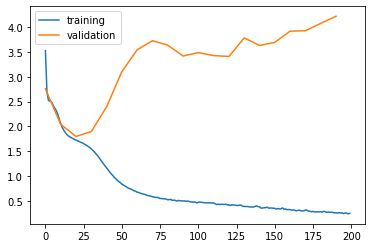

In [24]:
plt.plot(sum_loss_training, label="training")

x_validation = [i*mod_epoch for i in range(len(sum_loss_validation))]
plt.plot(x_validation, sum_loss_validation, label="validation")

plt.legend()
plt.show()

In [17]:
# Save model
torch.save(model.state_dict(), f"./model.{dtstamp}.{epoch}.ph")

# Print performance
pr.disable()
s = StringIO()
ps = pstats.Stats(pr, stream=s).strip_dirs().sort_stats("cumtime").print_stats(20)
print(s.getvalue())

         230706242 function calls (228064798 primitive calls) in 14597.495 seconds

   Ordered by: cumulative time
   List reduced from 2400 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       41    0.000    0.000 14597.178  356.029 interactiveshell.py:3293(run_code)
    45/41    0.000    0.000 14597.177  356.029 {built-in method builtins.exec}
     41/5    0.000    0.000 14594.401 2918.880 gen.py:716(run)
    65/18    0.000    0.000 14594.401  810.800 {method 'send' of 'generator' objects}
        4    0.000    0.000 14594.400 3648.600 base_events.py:1686(_run_once)
       74    0.000    0.000 14594.400  197.222 events.py:86(_run)
       74    0.000    0.000 14594.400  197.222 {method 'run' of 'Context' objects}
       56    0.000    0.000 14594.400  260.614 ioloop.py:735(_run_callback)
        3    0.000    0.000 14594.398 4864.799 ioloop.py:690(<lambda>)
        3    0.000    0.000 14594.398 4864.799 gen.py:784(inner)
    52/